In [1]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, GRU, Activation, Input, LSTM, Embedding,Flatten, ConvLSTM2D
import keras
import keras.utils as ku
from keras.preprocessing import sequence
import numpy as np
import pandas as pd
import time


Using TensorFlow backend.
/home/yes/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yes/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yes/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yes/.local/lib/python3.6/site-packages/tensorflow/python/framework/d

In [2]:
main_input = Input(shape=(2,), name = 'main_input')
x = Embedding(output_dim=10, input_dim=71, input_length=2)(main_input)
lstm_out = LSTM(256)(x)
head_out = Dense(1, activation='sigmoid', name='head_out')(lstm_out)
head_in = Input(shape=(1,),name='head_in')#,batch_shape=(100,2,1))
#head_in = Flatten()(head_in)
x = keras.layers.concatenate([lstm_out, head_in])
x = Dense(200, activation='relu')(x)
x = Dense(200, activation='relu')(x)
x = Dense(200, activation='relu')(x)
main_output = Dense(2, activation='tanh', name='main_output')(x)
model = keras.Model(inputs=[main_input, head_in], outputs=[main_output, head_out])

In [3]:
sgd = keras.optimizers.SGD(lr = 0.01, momentum=0.9)
#model.compile(loss='mean_squared_error', optimizer=sgd)
model.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=["mae"])
#model.summary()

In [ ]:
## set samps to how many samples you are using
## skip sample 0
import math
import re
for pee in range(5):
    print(pee)
    for i in range(1,100,15):
        j = 0
        #eva = [0,0]
        ## this loop goes through each tick of the sample sim
        sym = 0
        while True:
            try:
                data = pd.read_csv(f"./FlockData2/sample{i}/Flock{j}.csv")
                target = pd.read_csv(f"./FlockData2/sample{i}/Flock{j+1}.csv")
                x = np.array(data['xcor'])
                x0 = np.zeros((100))
                y = np.array(data['ycor'])
                y0 = np.zeros((100))
                nearNei = np.zeros((100))
                nn = np.array(data['nearest-neighbor'])
                heading = np.zeros((1,100,2))
                hRad = np.zeros((100))
                h = np.array(data["heading"]) 
                xT = np.array(target['xcor'])
                x1 = np.zeros((100))
                yT = np.array(target['ycor'])
                y1 = np.zeros((100))
                h1 = np.array(target["heading"])
                hT = np.zeros((1,100,2))
                hTRad =  np.zeros((100))
                for z in range(100):
                    x0[z] = round(float(x[z]+35))#float(x[z])/35
                    #print(x[z])
                    y0[z] = round(float(y[z]+35))#float(y[z])/35
                    x1[z] = float(xT[z])/35
                    y1[z] = float(yT[z])/35
                    #nearNei[z] = int(re.findall(r'\d+', nn[z])[0])/100
                    heading[0,z] = [math.sin(math.radians(int(h[z]))),math.cos(math.radians(int(h[z])))]
                    hRad[z] = int(h[z])/360
                    hT[0,z] = [math.sin(math.radians(int(h1[z]))),math.cos(math.radians(int(h1[z])))]
                    hTRad[z] = int(h[z])/360
                #print(np.shape(heading))
                inputs = np.zeros((100,2))
                if sym == 0:
                    inputs[:,0] = x0
                    inputs[:,1] = y0
                else:
                    inputs[:,0] = y0
                    inputs[:,1] = x0
                test[j] = inputs
                target = np.zeros((100,2))
                if sym == 0:
                    target[:,0] = x1
                    target[:,1] = y1
                else:
                    target[:,0] = y1
                    target[:,1] = x1
                #target = np.concatenate((target,hT),axis =2)
                #eva = model.evaluate(inputs,target)
                #hist = model.train_on_batch(inputs,hT,reset_metrics = False)
                hist = model.train_on_batch({'main_input':inputs,'head_in':hRad},{'main_output':target,
                        'head_out':hTRad},reset_metrics = False)
                #hist = model.evaluate({'main_input':inputs,'head_in':hRad},{'main_output':target,
                #        'head_out':hTRad},verbose = 0)
                #print(model.metrics_names)
                #print(hist)
                
                #if sym ==1:
                #    j +=1
                #    sym = 0
                #else:
                #    sym +=1 
                j+=1
            except:
                #print(eva)
                #print(j)
                break
    print(model.metrics_names)
    print(hist)

In [38]:
## sequence generation
x0,y0, hRAd = np.random.randint(0,71,size=(100,)),np.random.randint(0,71,size=(100,)),np.random.randint(1,360,size=(100))/360
scenes = []
inputs = np.zeros((100,2)) 
inputs[:,0] = x0
inputs[:,1] = y0
scenes.append(inputs)
for i in range(149):
    temp = model.predict({'main_input':inputs,'head_in':hRad})
    hRad = temp[1]
    inputs = np.round(temp[0]*35)+35
    scenes.append(inputs)

<IPython.core.display.Javascript object>


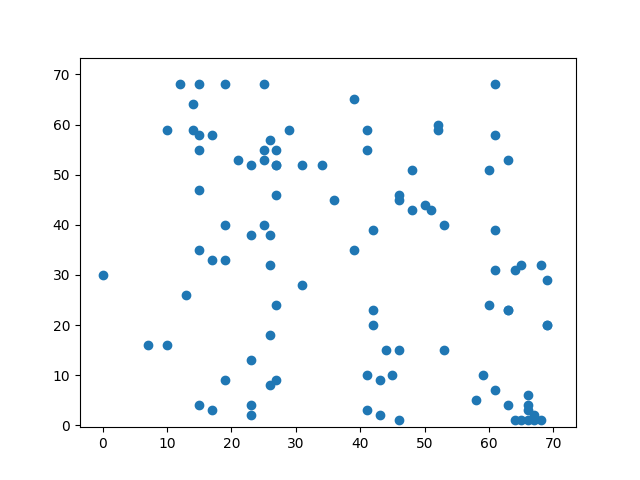

In [40]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
fig, ax = plt.subplots()
x0,y0, h0 = np.random.randint(-17,17,size=(100,)),np.random.randint(-17,17,size=(100,)),np.random.randint(-100,100,size=(100,2))
figs = []
temp = scenes[0].reshape(2,100)
scat = ax.scatter(temp[0],temp[1])
#x1,y1, h1 = np.random.randint(-17,17,size=(100,)),np.random.randint(-17,17,size=(100,)),np.random.randint(1,360,size=(100))

heading = h0/100
def animate(i):
    scat.set_offsets(scenes[i+1])
anim = FuncAnimation(fig, animate,frames = 148, interval=100)
plt.draw()
plt.show()
#for i in range(100):
    #temp = ax.scatter(p0[i][0],p0[i][1])
    #figs.append(temp)
#for j in figs:
#    j.set_data(23,0)

In [20]:
#model.save('boidsRNN.h5')
#print(hRad)
hist = model.predict({'main_input':inputs,'head_in':hRad})
#print(hist)
#print(target)

150

In [2]:
main_input = Input(shape=(1,), name = 'main_input')
x = Embedding(output_dim=2, input_dim=2, input_length=1)(main_input)
lstm_out = LSTM(256)(x)
head_out = Dense(2, activation='sigmoid', name='head_out')(lstm_out)
head_in = Input(shape=(2,),name='head_in')#,batch_shape=(100,2,1))
#head_in = Flatten()(head_in)
x = keras.layers.concatenate([lstm_out, head_in])
x = Dense(200, activation='relu')(x)
x = Dense(200, activation='relu')(x)
x = Dense(200, activation='relu')(x)
main_output = Dense(1, activation='tanh', name='main_output')(x)
virusModel = keras.Model(inputs=[main_input, head_in], outputs=[main_output, head_out])
virusModel.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=["mae"])

In [4]:

for e in range(1):
    print(f"epoch: {e}")
    startTime = time.perf_counter()
    for z in range(3,100,5):
        j = 0
        while True:
            try:
                target = pd.read_csv(f"./VirusData3/sample{z}/Virus{j+1}.csv")
                d = pd.read_csv(f"./VirusData3/sample{z}/Virus{j}.csv")
                x = np.array(d['xcor'])
                x0 = np.zeros((100))
                y = np.array(d['ycor'])
                y0 = np.zeros((100))
                
                xT = np.array(target['xcor'])
                x1 = np.zeros((100))
                yT = np.array(target['ycor'])
                y = np.zeros((100))
                
                target = np.array(target['sick?']).astype('float').reshape(1,100)
                #print(np.shape(target))
                s = np.array(d['sick?']).astype('float')#.reshape(1,100)
                for i in range(100):
                    try:      
                        if np.isnan(x[i]):
                            x0[i] = 0#17
                            
                        else:
                            x0[i] = float(x[i])/17
                            
                    except:
                        pass
                    try:      
                        if np.isnan(x[i]):
                            x1[i] = 0#17
                            
                        else:
                            x1[i] = float(xT[i])/17
                            
                    except:
                        pass
            
                    try:
                        if np.isnan(y[i]):
                            y0[i] = 0#17
                        else:
                            y0[i] = float(y[i])/17
                            
                    except:
                        pass
                    try:      
                        if np.isnan(x[i]):
                            y1[i] = 0#17
                            
                        else:
                            y1[i] = float(yT[i])/17
                            
                    except:
                        pass

                    if np.isnan(s[i]):
                        s[i] = 0
                    #elif s[i] == 0:
                    #    s[i] = -1
                    if np.isnan(target[0,i]):
                        target[0,i] = 0
                    #elif target[0,i] == 0:
                    #    target[0,i] = 0

                #inputs = np.concatenate((x0,y0,s)).reshape(300,)
                #print(target)
                inputs = np.zeros((100,2))
                inputs[:,0] = x0
                inputs[:,1] = y0
                s = s.reshape(100,1)
                hO = np.zeros((100,2))
                hO[:,0] = x0
                hO[:,1] = y0
                #inputs[:,2] = s
                #inputs = inputs.reshape(1,100,3)
                #print(inputs)
                #print(target,i)
                target = target.reshape(100,1)
                
                if z% 6 ==0:
                    hist = virusModel.evaluate({'main_input':s,'head_in':inputs},{'main_output':target,
                                                                    'head_out':hO},verbose=0)
                    #print(hist)
                else:
                    hist = virusModel.train_on_batch({'main_input':s,'head_in':inputs},{'main_output':target,
                                                                    'head_out':hO},reset_metrics=False)
                
                #print(j)
                #print(hist)
                j += 1
            except:
                print(virusModel.metrics_names)
                print(hist)
                print(z)
                break
    print(f"Run Time: {time.perf_counter() - startTime}")
    print(virusModel.metrics_names)
    print(hist)

virusModel.summary()

epoch: 0
['loss', 'main_output_loss', 'head_out_loss', 'main_output_mae', 'head_out_mae']
[0.009606459, 0.052819535, 0.09249145, 0.10374682, 0.20351139]
3
['loss', 'main_output_loss', 'head_out_loss', 'main_output_mae', 'head_out_mae']
[0.009508346, 0.038612124, 0.05725992, 0.0745448, 0.119776994]
8
['loss', 'main_output_loss', 'head_out_loss', 'main_output_mae', 'head_out_mae']
[0.00947823, 0.035009492, 0.047554325, 0.06711933, 0.09580458]
13
['loss', 'main_output_loss', 'head_out_loss', 'main_output_mae', 'head_out_mae']
[0.007253308814324555, 0.005670708604156971, 1.6483753029206127e-07, 0.012841460295021534, 0.00038173393113538623]
18
['loss', 'main_output_loss', 'head_out_loss', 'main_output_mae', 'head_out_mae']
[0.008156593, 0.021270711, 0.01582226, 0.037974276, 0.024014464]
23
['loss', 'main_output_loss', 'head_out_loss', 'main_output_mae', 'head_out_mae']
[0.00973073, 0.02502011, 0.021390349, 0.045696415, 0.031952895]
28
['loss', 'main_output_loss', 'head_out_loss', 'main_outp

NameError: name 'model' is not defined

In [40]:
round(min(x))

TypeError: '<' not supported between instances of 'float' and 'str'

In [34]:
x1,y1, h0 = np.random.randint(-17,17,size=(100,)),np.random.randint(-17,17,size=(100,)),np.random.randint(-100,100,size=(1,100,2))
np.shape(np.array([x1,y1]).T)
x = np.array(x1)/17
y = np.array(y1)/17
heading = h0/100
inputs = np.zeros((1,100,2))
inputs[0,:,0] = x
inputs[0,:,1] = y
print(i)
inputs = np.concatenate((inputs,heading),axis =2)
output = model.predict(inputs)


4


IndexError: index 99 is out of bounds for axis 0 with size 1

In [2]:
def customActivation(x):
    return x%1
model = Sequential()

model.add(layers.Dense(400,activation='sigmoid',input_shape=(100,4)))#,input_shape=(None,300)))
#model.add(layers.Dense(300,activation='relu'))
#model.add(layers.Dense(500,activation='relu'))
model.add(layers.Dropout(0.4))
#model.add(layers.Dense(500,activation='relu'))
model.add(layers.LSTM(256,return_sequences=True))
model.add(layers.Dropout(0.2))
#model.add(layers.Dropout(0.4))         
model.add(layers.Dense(2,activation='sigmoid'))
#model.add(Activation(customActivation))

In [16]:
data

,Unnamed: 0,heading,xcor,ycor,sick?,remaining-immunity,sick-time,age
0,0,51,-11.257440,10.630770,False,0,0,930.0
1,1,44,-2.362897,15.841234,False,0,0,137.0
2,2,72,-9.430460,-8.392363,False,0,0,234.0
3,3,277,6.136756,-15.891456,False,0,0,2091.0
4,4,199,-2.792280,-10.830074,True,0,1,1446.0
...,...,...,...,...,...,...,...,...
95,95,334,10.195878,-4.184493,False,0,0,1807.0
96,96,133,14.117419,-4.481686,False,0,0,1456.0
97,97,293,-7.854882,-8.621894,False,0,0,662.0
98,98,225,-16.804968,11.345687,False,0,0,477.0


In [17]:
d = pd.read_csv("./VirusData3/sample0/Flock0.csv")

,Unnamed: 0,heading,xcor,ycor,sick?,remaining-immunity,sick-time,age
0,0,61,7.013786929906611,-15.454478269450464,False,5.0,0.0,246.0
1,1,241,6.5647519526531015,9.153651747208142,False,41.0,0.0,2200.0
2,2,280,16.2305851595995,-1.7014778473373235,True,0.0,11.0,1555.0
3,3,312,-13.137895529721861,-4.9422270984384,False,4.0,0.0,1398.0
4,4,330,-7.485274248709061,-5.09413462989163,False,37.0,0.0,811.0
...,...,...,...,...,...,...,...,...
95,95,0,"""""",9.9,NaN,NaN,NaN,NaN
96,96,0,"""""",9.9,NaN,NaN,NaN,NaN
97,97,0,"""""",9.9,NaN,NaN,NaN,NaN
98,98,0,"""""",9.9,NaN,NaN,NaN,NaN


In [700]:
#norm info for virus
# area is 35x35
# but quards are divided by 17 to normalise [-17,17]
# age is out of 2600
# sick is bool
# dead is all 0
# how to represetn the time?
## first testing with just xcor/ycor/sick?
# output is whos sick
d = pd.read_csv("./VirusData3/sample0/Virus110.csv")

In [72]:
headline_data = np.round(np.abs(np.random.rand(12, 100) * 100))
additional_data = np.random.randn(12, 5)
headline_labels = np.random.randn(12, 1)
additional_labels = np.random.randn(12, 1)

array([[11., 52., 10., ..., 82., 77., 40.],
       [46., 53.,  6., ..., 71.,  5.,  8.],
       [11., 35., 77., ..., 19., 68., 53.],
       ...,
       [97., 71., 24., ..., 72.,  5., 10.],
       [80., 87., 10., ...,  4., 76.,  8.],
       [ 0., 87., 16., ..., 89., 40., 52.]])